# Lab 2 Exercises for COMP 432 Machine Learning

In this lab you'll translate mathematics from lecture into practical Numpy code. Specifically, you'll implement _linear least squares regression_ and _logistic regression_ "from scratch" and compare the results of your own implementations to those of *scikit-learn*, a popular machine learning package.

<span style="color:red"><i>Warning.</i></span> Many of the code cells in this notebook re-use the variable names like `X` or `y`, but assign them different data. If you run cells out of order, you may get unexpected results or errors, so be careful when switching between exercises.

**Run the code cell below** to import the required packages.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.linear_model

Lab2 requires a good understanding of Numpy and Matplotlib. Please complete Lab1 before attempting Lab2.

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

## 1. Plotting a 2D function and its gradient

Exercises 1.1&ndash;1.4 ask you to plot a function and its gradient, then optimize it with gradient descent.

<div style="border-bottom: 3px solid black;"></div>

### Exercise 1.1 &mdash; Evaluate a function on a 2D grid

The Python function below takes another function, *func*, as an argument, and evaluates it on a 2D grid.

In [5]:
def eval_on_grid_unvectorized(func, extent, numsteps):
    """
    Evaluates func(x1, x2) for each combination in a 2D grid.
      func: callable - function to evaluate for each grid element
      extent: tuple - grid extent as (x1min, x1max, x2min, x2max)
      numsteps: int - number of grid steps (same for each dimension)
    """
    x1min, x1max, x2min, x2max = extent
    x1 = np.empty((numsteps, numsteps))
    x2 = np.empty((numsteps, numsteps))
    y  = np.empty((numsteps, numsteps))
    for i in range(numsteps):
        for j in range(numsteps):
            x1[i,j] = x1min + j*(x1max-x1min)/(numsteps-1)
            x2[i,j] = x2min + i*(x2max-x2min)/(numsteps-1)
            y[i,j] = func(x1[i,j], x2[i,j])
    return x1, x2, y

**Run the code cell below** to see an example of its output.

In [7]:
x1, x2, y = eval_on_grid_unvectorized(lambda x1, x2: x1 + x2, (-1, 1, 0, 2), 3)
print("x1:"); print(x1)
print("x2:"); print(x2)
print("y:");  print(y)

x1:
[[-1.  0.  1.]
 [-1.  0.  1.]
 [-1.  0.  1.]]
x2:
[[0. 0. 0.]
 [1. 1. 1.]
 [2. 2. 2.]]
y:
[[-1.  0.  1.]
 [ 0.  1.  2.]
 [ 1.  2.  3.]]


**Write a vectorized version of *eval_on_grid*** in the code cell below. Your code should be fully vectorized, with no for-loops. Consider using [*np.meshgrid*](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html) and [*np.linspace*](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html).

In [18]:
def eval_on_grid_vectorized(func, extent, numsteps):
    x1min, x1max, x2min, x2max = extent
    _x1, _x2 = np.meshgrid(np.linspace(x1min, x1max, numsteps), np.linspace(x2min, x2max, numsteps))
    y = func(_x1, _x2)
    return _x1, _x2, y

**Check your answer** by running the code cell below.

In [19]:
args = (lambda x1, x2: x1 * x2, (-1, 1, -4, 4), 20)
r1 = eval_on_grid_unvectorized(*args)       # r1 = (x1, x2, y) for unvec version
r2 = eval_on_grid_vectorized(*args)         # r2 = (x1, x2, y) for vec version
for v1, v2 in zip(r1, r2):
    np.testing.assert_almost_equal(v1, v2)  # check that x1, x2, or y matches
print("Correct!")

import timeit
args = (lambda x1, x2: x1**2 + 0.5*x2, (0, 1, 0, 1), 200)
unvec_time = timeit.timeit('eval_on_grid_unvectorized(*args)', setup="from __main__ import eval_on_grid_unvectorized, args", number=10)
vec_time   = timeit.timeit('eval_on_grid_vectorized(*args)',   setup="from __main__ import eval_on_grid_vectorized, args", number=10)
print("Your vectorized code ran %.1fx faster than the original code on a 200x200 grid" % (unvec_time/vec_time))

Correct!
Your vectorized code ran 248.9x faster than the original code on a 200x200 grid


<div style="border-bottom: 3px solid black;"></div>

### Exercise 1.2 &mdash; Plot a function as a heatmap

Consider the function
$$
f(x_1, x_2) = (\textstyle \frac{1}{2}x_1 + x_2 + 1)^2 + (x_2 - 1)^2
$$

**Write code to compute $f(x_1, x_2)$**. Your code should run for $x_1$ and $x_2$ either numbers or Numpy arrays.

In [20]:
def f(x1, x2):
    # Your code here. Aim for 1-3 lines.
    return (((0.5 * x1) + x2 + 1)**2 + (x2 - 1)**2)

**Check your answer** by running the code cell below.

In [21]:
v = f(2.5, -4.0)
assert isinstance(v, float), "Expected float args to give float result"
assert v == 28.0625, "Wrong return value for float"
v = f(np.eye(3, 4), np.arange(12).reshape(3, 4))
assert isinstance(v, np.ndarray), "Expected ndarray args to give ndarray result"
np.testing.assert_equal(v, [[3.25, 4., 10., 20.], [34., 58.25, 74., 100.], [130., 164., 213.25, 244.]])
print("Correct!")

Correct!


**Write plotting code** to visualize your $f(x_1, x_2)$ function over the interval $x_1 \in [-6, 6]$ and $x_2 \in [-3, 3]$. Your plot should look like this:

<center><img style="display:inline" src="img/fig-exercise12-heatmap.png"/></center>

Specifically:

* Use your *eval_on_grid_vectorized* to compute all the grid positions and function values at sufficient resolution.
* Use [*plt.figure*](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.figure.html) with a *figsize* designed to make the plot twice as wide as it is tall
* Use [*plt.imshow*](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.imshow.html) and specify *origin* and *extent* to ensure the function values are plotted at the right positions.
* Use [*plt.colorbar*](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.colorbar.html) and specify *fraction=0.046/2* to make its height match the main figure
* Use [*plt.contour*](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) and use [*np.logspace*](https://numpy.org/doc/stable/reference/generated/numpy.logspace.html) to plot 5 contours logarithmically spaced between $0.1$ and $10$ inclusive.
* Configure the axis labels and title.

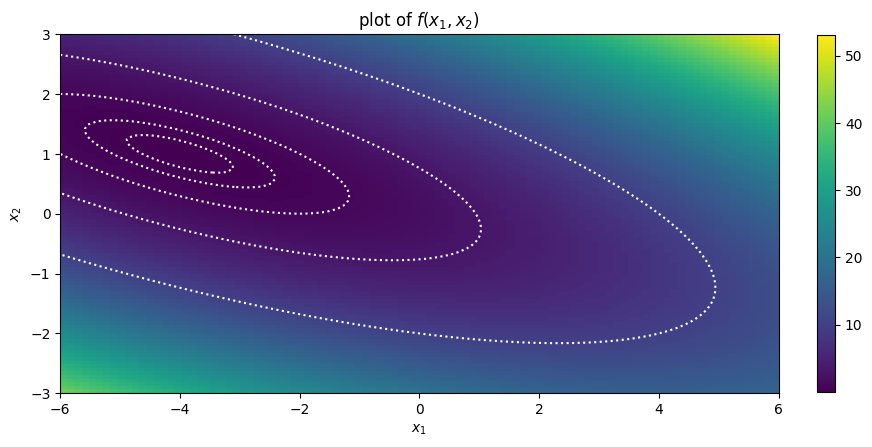

In [50]:
def plot_exercise12():
    # Your code here. Aim for 9-12 lines.
    extent = (-6, 6, -3, 3)
    x1, x2, y = eval_on_grid_vectorized(f, extent, 100)
    plt.figure(figsize=(10, 5))
    plt.imshow(y, origin='lower', extent=extent)
    plt.colorbar(fraction=0.046/2)
    plt.contour(x1, x2, y, np.logspace(-1, 1, 5), colors = 'white', linestyles= 'dotted')
    plt.title("Plot of $f(x_1, x_2)$")
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')

plot_exercise12()

<div style="border-bottom: 3px solid black;"></div>

### Exercise 1.3 &mdash; Plot gradients as a vector field

The gradient of $f(x_1, x_2)$ is a vector-valued function:
$$
\nabla f(x_1, x_2) = \begin{bmatrix}
\frac{\partial f}{\partial x_1}(x_1, x_2) \\
\frac{\partial f}{\partial x_2}(x_1, x_2) \\
\end{bmatrix}
$$

**Write code to compute $\nabla f(x_1, x_2)$**. You'll need to use basic calculus (differentiation) to figure out the correct formulas to implement, by yourself. Consider using [*np.stack*](https://numpy.org/doc/stable/reference/generated/numpy.stack.html) to form the final array of gradients.

In [ ]:
def f_grad(x1, x2):
    """
    Returns an ndarray 'grad' where grad[0,...] and grad[1,...] are the 1st and 
    2nd gradient components (respectively) when evaluated at x1[...] and x2[...].
    In other words, if x1 and x2 have shape (...) then grad has shape (2,...).
    """
    # Your code here. Aim for 1-3 lines.

**Check your answer** by running the code cell below.

In [ ]:
v = f_grad(3.5, -15.0)
assert isinstance(v, np.ndarray), "Expected float args to give ndarray result"
np.testing.assert_equal(v, [-12.25, -56.5])
v = f_grad(np.eye(3, 4), np.arange(12).reshape(3, 4))
assert isinstance(v, np.ndarray), "Expected array args to give ndarray result"
assert v.shape == (2, 3, 4), "Result was wrong shape"
np.testing.assert_equal(v, [[[ 1.5,  2. ,  3. ,  4. ], [ 5. ,  6.5,  7. ,  8. ], [ 9. , 10. , 11.5, 12. ]],
                            [[ 1. ,  4. ,  8. , 12. ], [16. , 21. , 24. , 28. ], [32. , 36. , 41. , 44. ]]])
print("Correct!")

**Write plotting code** to overlay the gradient $\nabla f(x_1, x_2)$ over your figure from Exercise 1.2. Your plot should look like this:

<center><img style="display:inline" src="img/fig-exercise12-vecfield.png"/></center>

Specifically:

* Use your *eval_on_grid_vectorized* to compute all the grid positions and gradient values at suitable resolution.
* Use [*plt.quiver*](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.quiver.html) to plot the vector field of gradients.

In [ ]:
def plot_exercise13():
    plot_exercise12()  # Start with your previous plot

    # Your code here. Aim for 2-4 lines.
    
plot_exercise13()

<div style="border-bottom: 3px solid black;"></div>

### Exercise 1.4 &mdash; Gradient descent on a function

Gradient descent is an iterative algorithm that repeatedly takes steps in the direction opposite the gradient:

$$
\mathbf{x}_\text{new} = \mathbf{x}_\text{old} - \eta \nabla f(\mathbf{x}_\text{old})
$$

where $\mathbf{x} = (x_1, x_2)$. The step size is scaled by the *learning rate*, which is chosen to be some constant $\eta \gt 0$.

**Write a function** that runs a specific number of steps of gradient descent on the function $f(x_1, x_2)$ from Exercise 1.2. To do this, use the *f_grad* function that you wrote for Exercise 1.3.

In [ ]:
def gradient_descent_on_f(x_init, learn_rate, num_steps):
    """
    Runs num_steps of gradient descent from point x_init using
    the given learning rate, and returns the new x coordinate.
    Here x_init is an ndarray with shape (2,).
    """
    # Your code here. Aim for 4-5 lines.

**Check your answer** by running the code cell below

In [ ]:
x = gradient_descent_on_f(np.array([-4, 1]), 100.0, 1)
assert isinstance(x, np.ndarray), "Expected ndarray"
assert np.array_equal(x, [-4, 1]), "Gradient descent shouldn't move away from optimal value!"
x = gradient_descent_on_f(np.array([2, 0]), 0.25, 1)
assert np.array_equal(x, [1.5, -0.5]), "The first gradient step seems to be wrong!"
x = gradient_descent_on_f(x, 0.1, 3)
assert np.allclose(x, [1.1294375, -0.369625]), "The gradient seems to be wrong after a few steps!"
print("Correct!")

**Plot the path of gradient descent** by running the code cell below. You should see a path of little red 'x' marks that converge near $(x_1^*, x_2^*)=(-4,1)$.


In [ ]:
plot_exercise13()  # Plot the vector field first

# Run gradient descent in chunks of 5 steps at a time, plotting the resulting 'x' after each chunk
learn_rate = 0.05
x_init = np.array([2.0, 1.0])                               # Start from initial point (-2, -1)
for num_steps in range(0, 250, 5):                            # Repeatedly run gradient descent from the initial point,
    x = gradient_descent_on_f(x_init, learn_rate, num_steps)  # eventually running it for 100 steps.
    plt.plot(*x, 'xr');                                    # Add a little 'x' to the plot to show how far it got.

*Optional:* Advanced students can try adding "momentum" to their implementation of *gradient_descent_on_f*, and then see how it effects the path of optimization. Relevant formulas and helpful visualizations regarding momentum can be found for example in [*Why Momentum Really Works*](https://distill.pub/2017/momentum/).

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

## 2. Linear least squares regression

Exercises 2.1&ndash;2.5 ask you to implement linear least squares regression, and to compare your results to applying the scikit-learn **[LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)** model.

<div style="border-bottom: 3px solid black;"></div>

### Exercise 2.1 &mdash; Vectorized code for generating predictions from a basic linear model

Recall from Lecture 1 that a basic linear model has the form:
$$
\hat{y}(\mathbf{x}, \mathbf{w}) = \mathbf{x}^T \mathbf{w}
$$
where 
$$
\begin{align}
\mathbf{x} &= \begin{bmatrix} 1 & x_1 & \ldots & x_D \end{bmatrix}^T\\
\mathbf{w} &= \begin{bmatrix} w_0 & w_1 & \ldots & w_D \end{bmatrix}^T
\end{align}
$$

If both $\mathbf{x}$ and $\mathbf{w}$ are column vectors, the following Python function would evaluate the linear model $\hat{y}(\mathbf{x}, \mathbf{w})$ correctly:
```python
def linear_model_predict(x, w):
    """Returns a prediction from linear model y(x, w) at point x using parameters w."""
    return x.T @ w   # Return the inner product (dot product) of vectors x and w
```
However, we want a version of *linear_model_predict* that vectorizes across many $\mathbf{x}$ simultaneously. Specifically, given a matrix of inputs:

$$
X = \begin{bmatrix}
\mathbf{x}_1^T\\
\vdots \\
\mathbf{x}_N^T
\end{bmatrix}
$$

we want *linear_model_predict* to compute a vector of outputs:

$$
\hat{\mathbf{y}} = \begin{bmatrix}
\mathbf{x}_1^T \mathbf{w}\\
\vdots\\
\mathbf{x}_N^T \mathbf{w}
\end{bmatrix}
$$

However, if we substitute $x$ with $X$ we can no longer use expression `X.T @ w`; the matrix $X^T \in \mathbb{R}^{(D+1) \times N}$ isn't even the right shape to be on the left-hand side of the product. Writing vectorized code is full of annoying little problems like this.

**Write a function** that evaluates the linear model in vectorized fashion. Specifically, when given a matrix $X \in \mathbb{R}^{N \times (D+1)}$ as an argument, you should figure out what mathematical expression would result in the $\hat{\mathbf{y}}\in\mathbb{R}^N$ vector shown above. Hint: the solution is only a small change from `X.T @ w`.

In [ ]:
def linear_model_predict(X, w):
    """
    Returns predictions from linear model y(X, w) at each point X[i,:] using parameters w.
    Given X with shape (N,D+1), w must have shape (D+1,) and the result will have shape (N,).
    """
    # Your code here. Aim for 1 line.

**Check your answer** by running the code cell below.

In [ ]:
w = np.array([2, 0.5])                            # Parameters corresponding to the 1D line y = 2 + 0.5*x1
X = np.array([[1., -3.], [1.,  3.], [1.,  5.]])   # Evaluate at x1 = -3, 2, 5
y = linear_model_predict(X, w)                    # Predict y for all X using w
assert isinstance(y, np.ndarray), "Expected an ndarray!"
assert np.array_equal(y, [0.5, 3.5, 4.5]), "Wrong predictions!\n%s" % y
try:
    y = linear_model_predict(X, w.reshape(-1, 1))
except ValueError:
    raise AssertionError("Your answer works when 'w' is 1-dimensional, but not when it is a column vector. Try again.")
w = np.array([1, 0.5, 0.25])                      # Parameters corresponding to the 2D plane y = 1 + 0.5*x1 + 0.25*x2
X = np.array([[1., -3., 1.], [1.,  3., 0.], [1.,  5., -2.]])   # Evaluate at different (x1, x2) points
y = linear_model_predict(X, w)                    # Predict y for all X using w
assert np.array_equal(y, [-0.25, 2.5, 3.0]), "Wrong predictions for 2-dimensional feature space!\n%s" % y
print("Correct!")

**Plot several predictions at once** by running the code cell below.

In [ ]:
w = np.array([2, 0.5])           # Parameters corresponding to the 1D line y = 2 + 0.5*x1
x0 = np.ones(20)                 # A column of 1s so that the bias term w[0] gets added
x1 = np.linspace(-5, 5, 20)      # A column of x values ranging from [-5, 5]
X = np.column_stack([x0, x1])    # A 20x2 matrix where X[i,:] is the ith x vector
y = linear_model_predict(X, w)   # Evaluate all x values
plt.scatter(x1, y, 10, 'r')
plt.xlabel("$x_1$")
plt.ylabel("$y$")
plt.title("Sample predictions for linear model $y=2 + \\frac{1}{2}x_1$");

<div style="border-bottom: 3px solid black;"></div>

### Exercise 2.2 &mdash; Linear least squares regression by gradient descent

Here you'll implement a 'learning' algorithm for linear least squares regression. Recall from Lecture 1 that the least squares training objective is:

$$
\ell(\mathbf{w}) = \frac{1}{2} \sum_{i=1}^N (y - \hat{y}(\mathbf{x}_i, \mathbf{w}))^2
$$

The gradient for the above training objective is on the slide titled "Linear least squares *learning*" from Lecture 1. You'll need it.

**Write a function** to implement linear least squares regression by gradient descent. Use the `@` operator (matrix multiplication) in your answer.

In [ ]:
def linear_regression_by_gradient_descent(X, y, w_init, learn_rate=0.05, num_steps=500):
    """
    Fits a linear model by gradient descent.
    
    If the feature matrix X has shape (N,D) the targets y should have shape (N,)
    and the initial parameters w_init should have shape (D,).
    
    Returns a new parameter vector w that minimizes the squared error to the targets.
    """
    # Your code here. Aim for 4-5 lines.

**Check your answer** by running the code cell below.

In [ ]:
X = np.array([[1, 0.0], [1, 1.0], [1, 2.0]])
y = np.array([4.0, 3.0, 2.0])
w = linear_regression_by_gradient_descent(X, y, np.array([0.0, 0.0]))
assert isinstance(w, np.ndarray), "Expected ndarray!"
assert w.shape == (2,), "Wrong shape for final parameters!\n%s" % w
assert np.allclose(w, [4, -1]), "Wrong values for final parameters!\n%s" % w
print("Correct!")

<div style="border-bottom: 3px solid black;"></div>

### Exercise 2.3 &mdash; Linear least squares regression by direct solution

As discussed in class, the optimal parameters $\mathbf{w}^*$ for linear least squares regression can be solved *directly*, rather than iteratively.

**Write a function** to solve linear least squares regression directly. Use Numpy's matrix inverse function **[np.linalg.inv](https://numpy.org/devdocs/reference/generated/numpy.linalg.inv.html)** in your answer.

In [ ]:
def linear_regression_by_direct_solve(X, y):
    """Fits a linear model by directly solving for the optimal parameter vector w."""
    # Your code here. Aim for 1-2 lines.

In [ ]:
w = linear_regression_by_direct_solve(X, y)
assert isinstance(w, np.ndarray), "Expected ndarray!"
assert w.shape == (2,), "Wrong shape for final parameters!\n%s" % w
assert np.allclose(w, [4, -1]), "Wrong values for final parameters!\n%s" % w
print("Correct!")

<div style="border-bottom: 3px solid black;"></div>

### Exercise 2.4 &mdash; Run linear least squares regression and plot the result

For this exercise you'll need to define Numpy arrays that correspond to the following training data:

$$
X = \begin{bmatrix}
1 & -2.2\\
1 & -0.3\\
1 &  1.5\\
1 &  4.8
\end{bmatrix}, \quad
\mathbf{y} = \begin{bmatrix}
-1.2 \\
1.5\\
4.2\\
5.3
\end{bmatrix}
$$

**Write code** to create the following plot:
![image](img/fig-linear-regression-1d-train-and-test.png)

Your code should follow this sequence of steps:
1. Make ndarrays $X$ and $\mathbf{y}$ that contain the above training set.
2. Plot the training set in blue. Use the $x$ coordinates from the second column of $X$, ignoring the first column.
3. Run linear least squares regression on $(X, \mathbf{y})$ to get fitted parameters $\mathbf{w}$; use your *linear_regression_by_direct_solve* function.
4. Define a "test set" of 20 equally-spaced values of $x$ in range $[-5, 5]$. You will need to build a new matrix $X_\text{test}$ with $1$ in the first column and the 20 distinct $x$ values in the second column. See how this is done in the last code cell of Exercise 2.1.
5. Predict 20 $y$ values corresponding to the 20 rows of $X_\text{test}$ by applying a linear model with your fitted parameters $\mathbf{w}$. Do this with single call to your *linear_model_predict* function. 
6. Plot the predictions on the test set.

In [ ]:
# 1. Define the training set. Aim for 2 lines.

# 2. Plot the training set. Aim for 1 line.

# 3. Run linear least squares regression on the training set to compute 'w'. Aim for 1 line.

# 4. Define the test set matrix of shape (20,2). Aim for 1-3 lines.

# 5. Use the linear model to make predictions on the test set. Aim for 1 line.

# 6. Plot the test predictions. Aim for 1 line, plus a few lines to configure the plot (axis labels etc).


<div style="border-bottom: 3px solid black;"></div>

### Exercise 2.5 &mdash; Run scikit-learn LinearRegression

The scikit-learn package provides a **[LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)** object to perform linear least squares regression (also known as "ordinary" least squares).

**Write code to fit a LinearRegression model** using the same training matrix $X$ that you defined as part of Exercise 2.4. There are only two steps:
1. Create the _LinearRegression_ object. Use the *fit_intercept=False* option when creating the *LinearRegression* object (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)), since the $X$ matrix already has a column of 1s corresponding to an intercept parameter (the 'bias' parameter).
2. Fit the _LinearRegression_ object to the training matrix $X$ and targets $\mathbf{y}$. Use the object's **[fit](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.fit)** method.

The variable holding a reference to your _LinearRegression_ object should be called `linear_model`, so that your answer can be checked.

In [ ]:
# Your code here. Aim for 2 lines.


**Check your answer** by running the code cell below. 

In [ ]:
assert 'linear_model' in globals(), "You didn't create a variable named 'linear_model'!"
assert isinstance(linear_model, sklearn.linear_model.LinearRegression), "Expected a LinearRegression instance!"
assert hasattr(linear_model, 'coef_'), "No model coefficients yet! You didn't fit the model to any data!"
assert linear_model.intercept_ == 0.0, "You forgot to disable fitting of the intercept!"
assert np.allclose(linear_model.coef_, [[1.57104472, 0.92521608]]), "The model parameters you learned seem incorrect!"
print("Correct!")

**Plot several LinearRegression model predictions at once** by running the code cell below.

In [ ]:
x0 = np.ones(20)                        # A column of 1s so that the bias term w[0] gets added
x1 = np.linspace(-5, 5, 20)             # A column of x values ranging from [-5, 5]
X_test = np.column_stack([x0, x1])      # A 20x2 matrix where X[i,:] is the ith x vector
y_test = linear_model.predict(X_test)   # Evaluate all x values
plt.scatter(x1, y_test, 10, 'r')
plt.scatter(X[:,1], y, edgecolor='b', facecolor='none')
plt.xlabel("$x_1$")
plt.ylabel("$y$")
plt.title("Sample predictions for LinearRegression model");

You can also compare the model's `coef_` attribute (coefficients, i.e. model parameters) to the parameter vector $\mathbf{w}$ that your own implementation gave from Exercise 2.4 (just use `print(w)` in your previous answer to see those values).

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

## 3. Logistic regression

Exercises 3.1&ndash;3.4 ask you to implement logistic regression, and to compare your results to applying the scikit-learn **[LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)** model.

<div style="border-bottom: 3px solid black;"></div>

### Exercise 3.1 &mdash; Vectorized code for generating predictions from a logistic model 

Recall from lecture that the logistic model has the form:
$$
\hat{y}(\mathbf{x}, \mathbf{w}) = \sigma(\mathbf{x}^T \mathbf{w})
$$

where $\mathbf{x}$ and $\mathbf{w}$ are the same as for Exercise 2.1 and $\sigma(\cdot)$ is the logistic sigmoid function described in Lecture 1.

**Write a function** that evaluates the logistic model in vectorized fashion, just like you did for Exercise 2.1.

In [ ]:
def sigmoid(z):
    """Returns the element-wise logistic sigmoid of z."""
    # Your code here. Aim for 1 line.
    
def logistic_model_predict(X, w):
    """
    Returns predictions from logistic model y(x, w) at each point X[i,:] using parameters w.
    Given X with shape (N,D+1), w must have shape (D+1,) and the result will have shape (N,).
    """
    # Your code here. Aim for 1-2 lines.

**Check your answer** by running the code cell below.

In [ ]:
y = sigmoid(np.array([-1., 0., 1.5]))
assert isinstance(y, np.ndarray), "Expected an ndarray!"
assert np.allclose(y, [0.26894142, 0.5, 0.81757448]), "Values from sigmoid() appear to be wrong!"
w = np.array([2, 1.5])                           # Parameters corresponding to logistic model y = sigmoid(2 + 1.5*x1)
X = np.array([[1., -2.], [1.,  0.], [1.,  2.]])  # Evaluate at x1 = -2, 0, 2
y = logistic_model_predict(X, w)                 # Predict y for all X using w
assert isinstance(y, np.ndarray), "Expected an ndarray!"
assert np.allclose(y, [0.26894142, 0.88079708, 0.99330715]), "Wrong returned!\n%s" % y
try:
    y = logistic_model_predict(X, w.reshape(-1, 1))
except ValueError:
    raise AssertionError("Your answer works when 'w' is 1-dimensional, but not when it is a column vector. Try again.")
w = np.array([1, 0.5, 0.25])                      # Parameters corresponding to the 2D plane y = 1 + 0.5*x1 + 0.25*x2
X = np.array([[1., -3., 1.], [1.,  3., 0.], [1.,  5., -2.]])   # Evaluate at different (x1, x2) points
y = logistic_model_predict(X, w)                  # Predict y for all X using w
assert np.allclose(y, [0.4378235, 0.92414182, 0.95257413]), "Wrong predictions for 2-dimensional feature space!\n%s" % y
print("Correct!")

**Plot several predictions at once** by running the code cell below.

In [ ]:
w = np.array([2, 1.5])                       # Parameters corresponding to logistic model y = sigmoid(2 + 1.5*x1)
x0 = np.ones(20)                             # A column of 1s so that the bias term w[0] gets added
x1 = np.linspace(-5, 5, 20)                  # A column of x values ranging from [-5, 5]
X_test = np.column_stack([x0, x1])           # A 20x2 matrix where X[i,:] is the ith x vector
y_test = logistic_model_predict(X_test, w)   # Evaluate all x values
plt.scatter(x1, y_test, 10, 'r')
plt.xlabel("$x_1$")
plt.ylabel("$y$")
plt.title("Sample predictions for logistic model $y=\sigma(2 + \\frac{3}{2}x_1)$");

<div style="border-bottom: 3px solid black;"></div>

### Exercise 3.2 &mdash; Logistic regression by gradient descent

Recall from Lecture 1 that the basic logistic regression training objective (learning objective) is:

$$
\ell_\text{LR}(\mathbf{w}) = \sum_{i=1}^N y_i \ln \sigma(\mathbf{w}^T \mathbf{x}_i) + (1-y_i) \ln \left(1-\sigma(\mathbf{w}^T \mathbf{x}_i)\right)
$$

The "basic" gradient for the above training objective is on a slide titled "Maximum likelihood estimate for LR" from Lecture 1, and reproduced here:

$$
\nabla \ell_\text{LR}(\mathbf{w}) = \sum_{i=1}^N (\sigma(\mathbf{w}^T \mathbf{x}_i) - y_i)\mathbf{x}_i
$$

**Write a function** to implement logistic regression by gradient descent. Your answer to _logistic_regression_grad_ should ideally be fully vectorized (no for-loops), but this may take a while to figure out. If you can't figure out the vectorization, it's OK &mdash; just compute the gradient however you can. Your answer to _logistic_regression_ should use your _logistic_regression_grad_ function to compute the gradient at each step.

Implementing _logistic_regression_grad_ is the hardest exercise in this lab because a vectorized implementation requires using the `@` matrix multiply operator to compute all the $\mathbf{w}^T \mathbf{x}$ products, reshaping the vector of residuals into a column-vector to use Numpy's broadcasting feature, and then summing over a specific axis (over training cases $i=1,\ldots,N$).

In [ ]:
def logistic_regression_grad(X, y, w):
    """Returns the gradient for basic logistic regression."""
    # Your code here. Aim for 1-3 lines.

def logistic_regression(X, y, w_init, learn_rate=0.05, num_steps=500):
    """
    Fits a logistic model by gradient descent.
    
    If the feature matrix X has shape (N,D) the targets y should have shape (N,)
    and the initial parameters w_init should have shape (D,).
    
    Returns a new parameter vector w that minimizes the negative log likelihood of the targets.
    """
    # Your code here. Aim for 4-5 lines.

**Check your answer** by running the code cell below.

In [ ]:
X = np.array([[1, -1.0], [1, 1.0], [1, 2.0]])
y = np.array([0.0, 0.0, 1.0])
grad = logistic_regression_grad(X, y, np.array([0.0, 1.0]))
assert isinstance(grad, np.ndarray), "Expected ndarray from logistic_regression_grad!"
assert grad.shape == (2,), "Expected gradient to have shape (2,) but was %s" % (grad.shape,)
assert np.allclose(grad, [0.88079708, 0.22371131]), "Wrong value for gradient!"
grad = logistic_regression_grad(X, y, np.array([-1.0, 1.5]))
assert np.allclose(grad, [0.57911459, 0.30819531]), "Wrong value for gradient!"
w = logistic_regression(X, y, np.array([1.0, 0.0]))
assert isinstance(w, np.ndarray), "Expected ndarray from logistic_regression!"
assert w.shape == (2,), "Expected parameter vector w to have shape (2,) but was %s" % (w.shape,)
assert np.allclose(w, [-4.14100532, 2.95489589]), "Parameters found by gradient descent seem wrong!"
print("Correct!")

### Exercise 3.3 &mdash; Run logistic regression on data and plot the result

For this exercise you'll need to define Numpy arrays that correspond to the following training data:

$$
X = \begin{bmatrix}
1 & -4.1\\
1 & -2.8\\
1 & -0.7\\
1 &  3.5
\end{bmatrix}, \quad
\mathbf{y} = \begin{bmatrix}
0 \\
0\\
1\\
1
\end{bmatrix}
$$

**Write code** to create the following plot:
![image](img/fig-logistic-regression-1d-train-and-test.png)

Your code should follow this sequence of steps, which are the same as for Exercise 2.4:
1. Make ndarrays $X$ and $\mathbf{y}$ that contain the above training set.
2. Plot the training set in blue. Use the $x$ coordinates from the second column of $X$, ignoring the first column.
3. Run logistic regression on $(X, \mathbf{y})$ to get fitted parameters $\mathbf{w}$; use your *logistic_regression* function, starting from $\mathbf{w}_\text{init} = \begin{bmatrix} 0.0, 1.0 \end{bmatrix}^T$
4. Define a "test set" of 20 equally-spaced values of $x$ in range $[-5, 5]$. You will need to build a new matrix $X_\text{test}$ with $1$ in the first column and the 20 distinct $x$ values in the second column.
5. Predict 20 $y$ values corresponding to the 20 rows of $X_\text{test}$ by applying a logistic model with your fitted parameters $\mathbf{w}$. Do this with single call to your *logistic_model_predict* function. 
6. Plot the predictions on the test set.

In [ ]:
# 1. Define the training set. Aim for 2 lines.

# 2. Plot the training set. Aim for 1 line.

# 3. Run logistic regression on the training set to get 'w'. Aim for 1-2 lines.

# 4. Define the test set matrix of shape (20,2). Aim for 1-3 lines.

# 5. Use the linear model to make predictions on the test set. Aim for 1 line.

# 6. Plot the test predictions. Aim for 1 line, plus a few lines to configure the plot (axis labels etc).


<div style="border-bottom: 3px solid black;"></div>

### Exercise 3.4 &mdash; Run scikit-learn LogisticRegression

The scikit-learn package provides a **[LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)** object to perform logistic regression.

**Write code to fit a LogisticRegression model** using the same training matrix $X$ that you defined as part of Exercise 3.3. There are only two steps:
1. Create the _LogisticRegression_ object. Do not fit an "intercept" and do not include any regularization penalty (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)).
2. Fit the _LogisticRegression_ object to the training matrix $X$ and targets $\mathbf{y}$. Use the object's **[fit](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.fit)** method.

The variable holding a reference to your _LogisticRegression_ object should be called `logistic_model`, so that your answer can be checked.

A tweet regarding the fact that scikit-learn's LogisticRegression object applies regularization (a weight penalty) "by default":
![image](img/fig-logistic-regression-regularization-tweet.png)

In [ ]:
# Your code here. Aim for 2 lines.

**Check your answer** by running the code cell below.

In [ ]:
assert 'logistic_model' in globals(), "You didn't create a variable named 'logistic_model'!"
assert isinstance(logistic_model, sklearn.linear_model.LogisticRegression), "Expected a LogisticRegression instance!"
assert hasattr(logistic_model, 'coef_'), "No model coefficients yet! You didn't fit the model to any data!"
assert logistic_model.intercept_ == 0.0, "You forgot to disable fitting of the intercept!"
assert np.allclose(logistic_model.coef_, [[18.5251137, 10.49283446]]), "The parameters seem incorrect! Not L-BFGS? Used penalty?"
print("Correct!")

Notice that the model parameters (coefficients) found by the _LogisticRegression_ are much larger than those found by your gradient descent solver. That is only because scikit-learn uses a more powerful optimization algorithm and can learn very sharp decision boundaries in fewer steps than mere gradient descent can. If you increase your *num_steps* argument your solver will find similarly large coefficients.

**Plot several LogisticRegression predictions at once** by running the code cell below.

In [ ]:
x0 = np.ones(50)                               # A column of 1s so that the bias term w[0] gets added
x1 = np.linspace(-5, 5, 50)                    # A column of x values ranging from [-5, 5]
X_test = np.column_stack([x0, x1])             # A 20x2 matrix where X[i,:] is the ith x vector
y_test = logistic_model.predict_proba(X_test)  # Evaluate all x values and get two probabilities back (class 0, class 1)
plt.scatter(x1, y_test[:,1], 10, 'r')          # Plot probability of class 1 only
plt.scatter(X[:,1], y, edgecolor='b', facecolor='none')
plt.xlabel("$x_1$")
plt.ylabel("$y$")
plt.title("Sample predictions for LogisticRegression model");